# Goal: overfit the first batch of MNIST samples
(for debugging)

In [1]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
%load_ext autoreload
import sys
sys.path.append("../../experiments/")
from functools import partial
from itertools import cycle

import numpy as onp
import jax
from jax import numpy as jnp
from jax import jit, grad, value_and_grad, vmap, pmap, config, random
config.update("jax_debug_nans", False)
from jax.ops import index_update, index
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import tensorflow_datasets as tfds

import haiku as hk
import optax

import nets
import utils
import models
import metrics
from convnet import model, accuracy, crossentropy_loss, log_prior, ensemble_accuracy

import os
on_cluster = not os.getenv("HOME") == "/home/lauro"

# Config
key = random.PRNGKey(0)
EPOCHS = 1
NUM_VALS = 20

META_LEARNING_RATE = 1e-3

NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 10**2
# STEP_SIZE = 1e-7 * 2 * LAMBDA_REG
STEP_SIZE = 1e-9 * 2 * LAMBDA_REG #10 #50
PATIENCE = 10


if USE_PMAP:
    vpmap = pmap
else:
    vpmap = vmap

# Load MNIST
data_dir = './data' if on_cluster else '/tmp/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

# Full train and test set
train_images, train_labels = train_data['image'], train_data['label']
test_images, test_labels = test_data['image'], test_data['label']

# Split off the validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=0)
data_size = len(train_images)


# get first batch
images, labels = train_images[:BATCH_SIZE], train_labels[:BATCH_SIZE]


def loss(params): # rescaled (narrowed) logp
    """Minibatch approximation of the (unnormalized) Bayesian
    negative log-posterior evaluated at `params`. That is,
    -log model_likelihood(data_batch | params) * batch_rescaling_constant - log prior(params))"""
    logits = model.apply(params, images)
    return 100 * data_size/BATCH_SIZE * crossentropy_loss(logits, labels) - log_prior(params)

# Neural SVGD Model
* Input: model parameters
* Output: 'gradient' of same shape as parameters

### Memory
Assume: convnet model has 50.000 parameters, and NSVGD layers have hidden dimensions `[1024, 1024]`. Then the NSVGD (meta) model has `2*50.000*1024` parameters (each 8 bytes), i.e. about 800MB.

The activations: `50.000 + 1024 + 1024 + 50.000` floats, i.e. about 800KB, times `NUM_SAMPLES`.

In [2]:
# Utility functions for dealing with parameters
key, subkey = random.split(key)
params_tree = model.init(subkey, train_images[:2])
params_flat, unravel = jax.flatten_util.ravel_pytree(params_tree)


def ravel(tree):
    return jax.flatten_util.ravel_pytree(tree)[0]


def init_flat_params(key):
    return ravel(model.init(key, train_images[:2]))


def sample_tv(key):
    """return two sets of particles at initialization, for
    training and validation in the warmup phase"""
    return vmap(init_flat_params)(random.split(key, NUM_SAMPLES)).split(2)


def acc(param_set_flat):
    return ensemble_accuracy(vmap(unravel)(param_set_flat),
                             val_images[:BATCH_SIZE],
                             val_labels[:BATCH_SIZE])


def vmean(fun):
    """vmap, but computes mean along mapped axis"""
    def compute_mean(*args, **kwargs):
        return jnp.mean(vmap(fun)(*args, **kwargs), axis=-1)
    return compute_mean

# init particles and dynamics model

In [3]:
key, subkey = random.split(key)
init_particles = vmap(init_flat_params)(random.split(subkey, NUM_SAMPLES))

opt = optax.sgd(STEP_SIZE)

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               target_logp=lambda flat_p: loss(unravel(flat_p)),
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[64, 64, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE)
particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

# train

In [4]:
# Warmup on first batch
NUM_WARMUP_STEPS = 100
key, subkey = random.split(key)
neural_grad.warmup(subkey,
                   sample_tv,
                   n_iter=NUM_WARMUP_STEPS // 30 + 1,
                   n_inner_steps=100,
                   progress_bar=True)

100%|██████████| 4/4 [00:18<00:00,  4.63s/it]


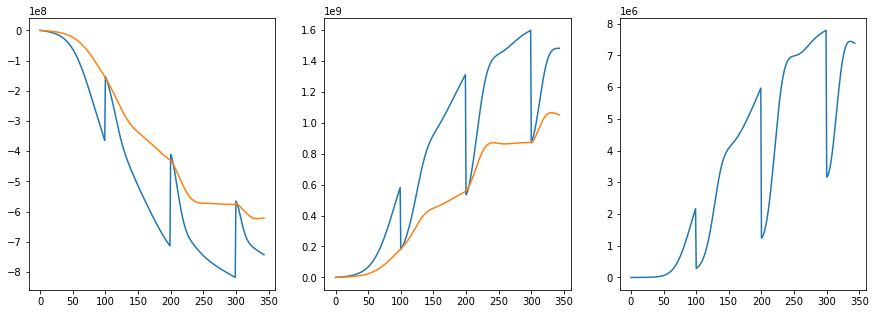

In [5]:
fig, axs = plt.subplots(1, 3, figsize=[15, 5])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'])
ax.plot(neural_grad.rundata['validation_loss'])

ax = axs[1]
ax.plot(neural_grad.rundata['training_sd'])
ax.plot(neural_grad.rundata['validation_sd'])

ax = axs[2]
ax.plot(neural_grad.rundata['l2_norm'])

In [6]:
def step(key):
    """one iteration of the particle trajectory simulation"""
    neural_grad.train(split_particles=particles.next_batch(key),
                      n_steps=100)
    particles.step(neural_grad.get_params())


def evaluate():
    train_logp = vmean(lambda p: loss(unravel(p)))
    stepdata = {
        "accuracy": acc(particles.particles),
#         "test_logp": -test_logp(particles.particles),
        "training_logp": -train_logp(particles.particles),
        "particle_mean": particles.particles.mean(),
    }
    metrics.append_to_log(particles.rundata, stepdata)

In [7]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
num_steps = 11
for step_counter in tqdm(range(num_steps)):
    key, subkey = random.split(key)
    step(subkey)
#     if step_counter % (num_steps//NUM_VALS) == 0:
    if step_counter % 5 == 0:
        evaluate()
# neural_grad.done()
# particles.done()

100%|██████████| 11/11 [00:56<00:00,  5.17s/it]


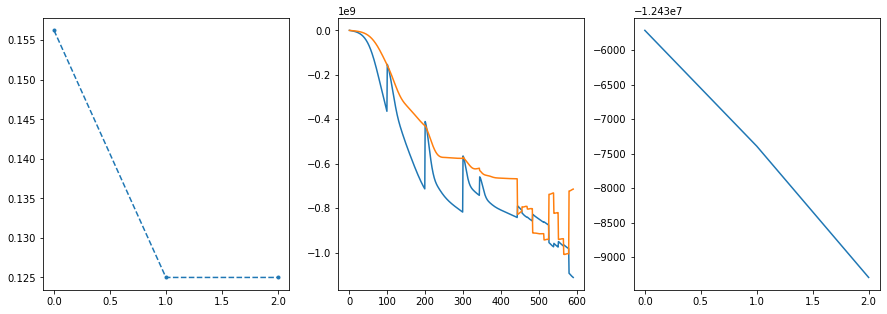

In [8]:
fig, axs = plt.subplots(1, 3, figsize=[15, 5])

ax = axs[0]
ax.plot(particles.rundata["accuracy"], "--.")

ax = axs[1]
ax.plot(neural_grad.rundata['training_loss'])#[200:250])
ax.plot(neural_grad.rundata['validation_loss'])#[200:250])

ax = axs[2]
ax.plot(particles.rundata['training_logp'])
# ax.plot(particles.rundata['test_logp'])

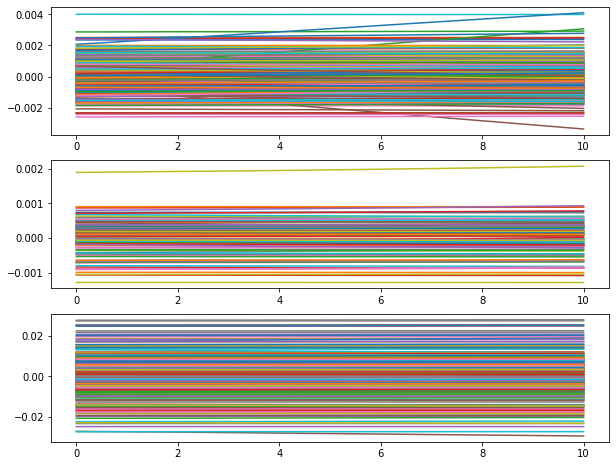

In [9]:
# visualize trajectories
trajectories = onp.array(particles.rundata['particles'])
fig, axs = plt.subplots(3, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=1)); # avg across particles (distinguish dims, ie parameters)

ax = axs[1]
ax.plot(trajectories.mean(axis=2)); # avg across dims (distinguish particles)

ax = axs[2]
ax.plot(trajectories[:, 10, :]);

In [21]:
len(neural_grad.rundata['gradient_norms'])

592

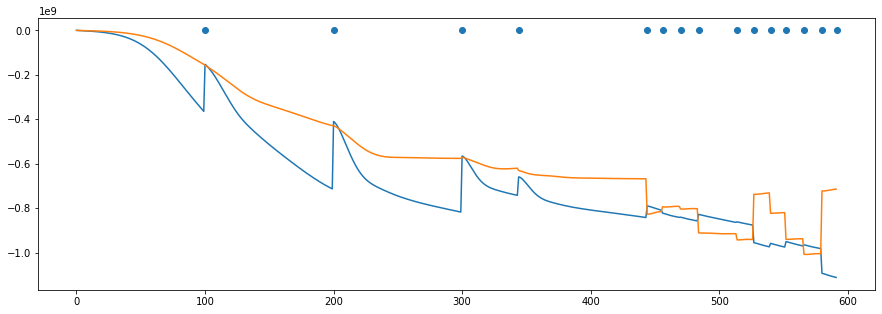

In [11]:
# generate markings based on num_steps
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])
num_train_steps = len(neural_grad.rundata['train_steps'])

plt.plot(neural_grad.rundata['training_loss'])
plt.plot(neural_grad.rundata['validation_loss'])
plt.scatter(markings, onp.zeros(num_train_steps))

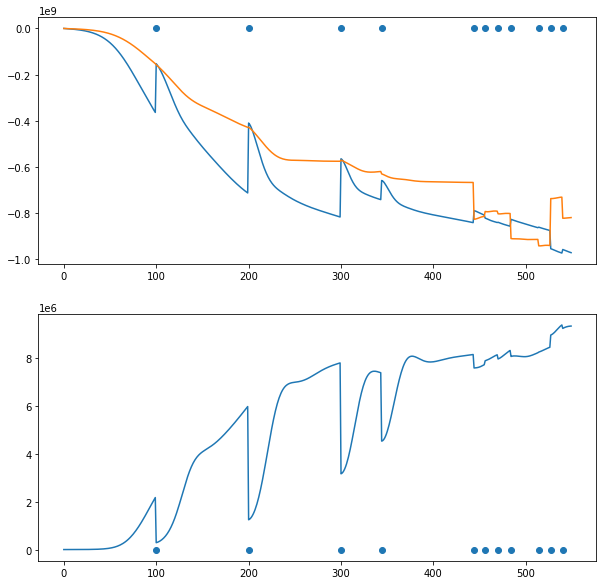

In [12]:
a = 000
b = 550
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'][a:b])
ax.plot(neural_grad.rundata['validation_loss'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2_norm'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

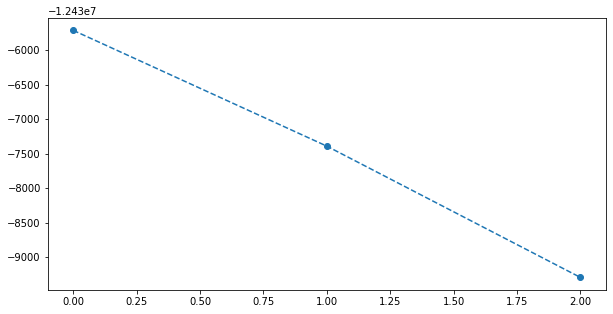

In [13]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(onp.array(particles.rundata['training_logp']), '--o')
# ax.set_yscale("log")

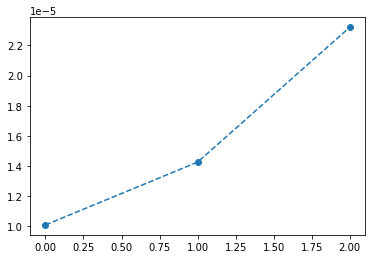

In [14]:
plt.plot(particles.rundata['particle_mean'], "--o")

In [15]:
particles.rundata['particle_mean']

[DeviceArray(1.0098413e-05, dtype=float32),
 DeviceArray(1.4258831e-05, dtype=float32),
 DeviceArray(2.3199282e-05, dtype=float32)]

In [16]:
neural_grad.rundata.keys()

dict_keys(['train_steps', 'gradient_norms', 'l2_norm', 'mean_drift', 'mean_repulsion', 'step_counter', 'training_loss', 'training_sd', 'validation_loss', 'validation_sd'])

In [17]:
particles.rundata.keys()

dict_keys(['mean', 'particles', 'std', 'step', 'accuracy', 'training_logp', 'particle_mean'])

In [18]:
len(neural_grad.rundata['gradient_norms'])

592

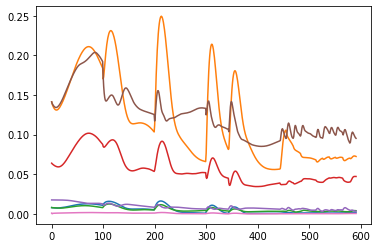

In [19]:
plt.plot(neural_grad.rundata['gradient_norms'])

In [20]:
neural_

NameError: name 'neural_' is not defined

In [ ]:
particles.particles.shape